In [1082]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Exploração inicial:

In [1083]:
df = pd.read_csv("../databases/tratado/consumo residencial por UF/consumo residencial bahia.csv",index_col=0)

In [1084]:
df.head(5)

,consumo
data,
31/01/2004,294798
29/02/2004,269980
31/03/2004,276717
30/04/2004,290815
31/05/2004,282304


In [1085]:
df.tail(5)

,consumo
data,
31/08/2023,612484
30/09/2023,655231
31/10/2023,661873
30/11/2023,703405
31/12/2023,718461


In [1086]:
df.describe()

,consumo
count,240.00000
mean,488621.67500
std,129586.80255
min,247536.00000
25%,368417.00000
50%,514150.00000
75%,594730.50000
max,718461.00000


In [1087]:
#Converter o tipo do indice para data
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")

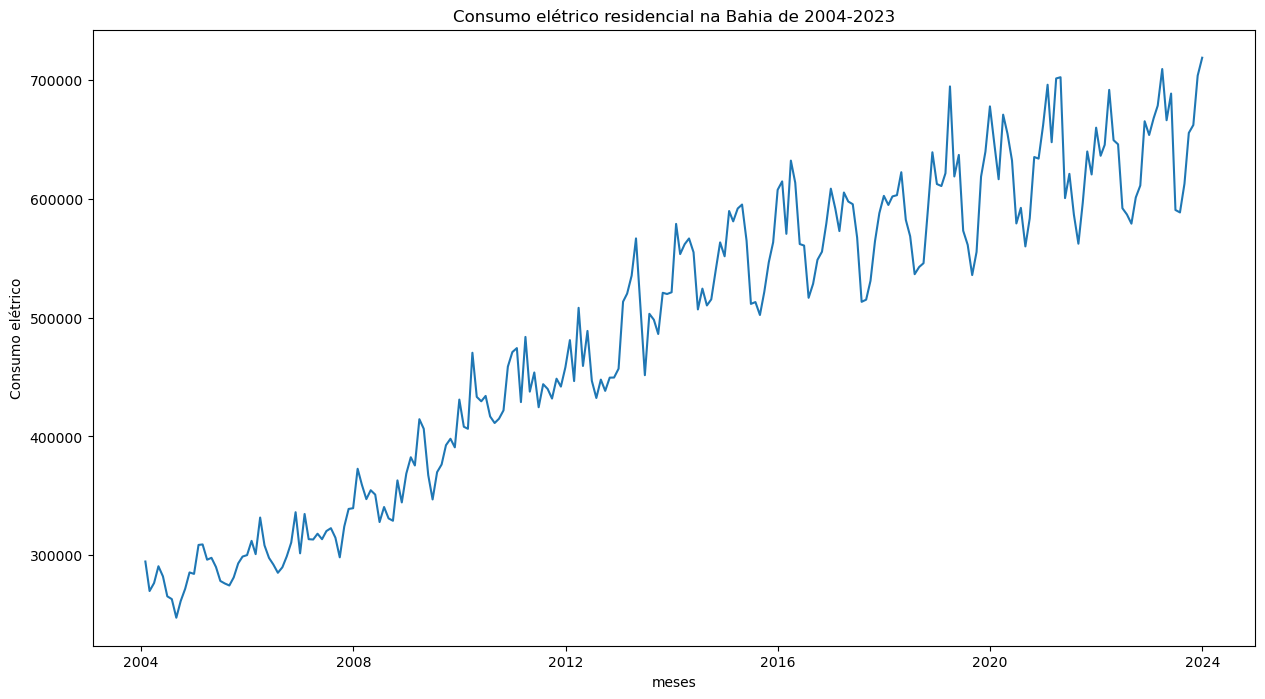

In [1088]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df["consumo"], label="Consumo elétrico mensal residencial na Bahia, 2004-2023")
plt.ylabel("Consumo elétrico")
plt.xlabel("meses")
plt.title("Consumo elétrico residencial na Bahia de 2004-2023")
plt.show()

Previsão

In [1089]:
#Separando em treino e teste
TREINO_PROPORCAO = .8
tamanho = len(df)
treino_df=df.iloc[:int(tamanho * TREINO_PROPORCAO)].copy()
teste_df = df.iloc[int(tamanho * TREINO_PROPORCAO):].copy()

In [1090]:
#Quantos para treino e teste?
print("Para treino", treino_df.shape[0])
print("Para teste",teste_df.shape[0])

Para treino 192
Para teste 48


In [1091]:
from sklearn.preprocessing import MinMaxScaler
escalador = MinMaxScaler()
treino_escalado = escalador.fit_transform(treino_df)
#treino_escalado = treino_df.values
teste_escalado = escalador.transform(teste_df)
#teste_escalado = teste_df.values

In [1092]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [1093]:
TIME_STEPS = 5
X_train, y_train = create_dataset(treino_escalado, treino_escalado, TIME_STEPS)
X_test, y_test = create_dataset(teste_escalado, teste_escalado, TIME_STEPS)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(187, 5, 1) (187, 1)
(43, 5, 1) (43, 1)


In [1094]:
treino_escalado[:6]

array([[0.10577935],
       [0.05023299],
       [0.06531139],
       [0.0968648 ],
       [0.07781593],
       [0.04024638]])

In [1095]:
X_train

array([[[0.10577935],
        [0.05023299],
        [0.06531139],
        [0.0968648 ],
        [0.07781593]],

       [[0.05023299],
        [0.06531139],
        [0.0968648 ],
        [0.07781593],
        [0.04024638]],

       [[0.06531139],
        [0.0968648 ],
        [0.07781593],
        [0.04024638],
        [0.03503597]],

       [[0.0968648 ],
        [0.07781593],
        [0.04024638],
        [0.03503597],
        [0.        ]],

       [[0.07781593],
        [0.04024638],
        [0.03503597],
        [0.        ],
        [0.03124231]],

       [[0.04024638],
        [0.03503597],
        [0.        ],
        [0.03124231],
        [0.0544989 ]],

       [[0.03503597],
        [0.        ],
        [0.03124231],
        [0.0544989 ],
        [0.085213  ]],

       [[0.        ],
        [0.03124231],
        [0.0544989 ],
        [0.085213  ],
        [0.08251156]],

       [[0.03124231],
        [0.0544989 ],
        [0.085213  ],
        [0.08251156],
        [0.13701

In [1096]:
y_train

array([[0.04024638],
       [0.03503597],
       [0.        ],
       [0.03124231],
       [0.0544989 ],
       [0.085213  ],
       [0.08251156],
       [0.13701494],
       [0.13794601],
       [0.10922609],
       [0.11273327],
       [0.09540777],
       [0.06920801],
       [0.06442061],
       [0.06067171],
       [0.07582845],
       [0.1022565 ],
       [0.1150878 ],
       [0.11787206],
       [0.14466269],
       [0.1196581 ],
       [0.1885371 ],
       [0.13614877],
       [0.11258555],
       [0.10011459],
       [0.08458632],
       [0.09491985],
       [0.11537876],
       [0.141583  ],
       [0.19857296],
       [0.12121138],
       [0.19524707],
       [0.14783862],
       [0.14717837],
       [0.15811172],
       [0.1477961 ],
       [0.16308712],
       [0.16853477],
       [0.15066093],
       [0.11363972],
       [0.17164132],
       [0.20475025],
       [0.20611999],
       [0.28038621],
       [0.25050246],
       [0.22320601],
       [0.23994512],
       [0.231

In [1097]:
from sklearn.svm import SVR

modelo = SVR(kernel="rbf", gamma=0.05, epsilon=0.05, C = 2)

In [1098]:
modelo.fit(X_train.reshape(X_train.shape[0], -1), y_train)

d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=2, epsilon=0.05, gamma=0.05)

In [1099]:
treino_previsao = modelo.predict(X_train.reshape(X_train.shape[0], -1))
teste_previsao = modelo.predict(X_test.reshape(X_test.shape[0], -1))

Realisando as inversões

In [1100]:
treino_previsao_inv = escalador.inverse_transform(treino_previsao.reshape(-1, 1))
y_train_inv = escalador.inverse_transform(y_train.reshape(-1, 1))
teste_previsao_inv = escalador.inverse_transform(teste_previsao.reshape(-1, 1))
y_test_inv = escalador.inverse_transform(y_test.reshape(-1, 1))

Checando a eficiência

In [1101]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [1102]:
from sklearn.metrics import mean_absolute_percentage_error

In [1103]:
mse_treino = mean_squared_error(y_train_inv, treino_previsao_inv)
mse_teste = mean_squared_error(y_test_inv, teste_previsao_inv)

In [1104]:
mape_treino = mean_absolute_percentage_error(y_train_inv, treino_previsao_inv)
mape_teste = mean_absolute_percentage_error(y_test_inv, teste_previsao_inv)

In [1105]:
print("Mean Squared Error (treino)",mse_treino, sep=" ")
print("Mean Squared Error (teste)",mse_teste, sep=" ")

Mean Squared Error (treino) 695901838.8270032
Mean Squared Error (teste) 1705604673.8240888


In [1106]:
print("Mean Absolute Percentagem Error (treino)",mape_treino, sep=" ")
print("Mean Absolute Percentagem Error (teste)",mape_teste, sep=" ")

Mean Absolute Percentagem Error (treino) 0.04459216811108303
Mean Absolute Percentagem Error (teste) 0.05350306330801152


In [1107]:
mae_treino = mean_absolute_error(y_train_inv, treino_previsao_inv)
mae_teste = mean_absolute_error(y_test_inv, teste_previsao_inv)

In [1108]:
print("Mean Absolute Error (treino)",mae_treino, sep=" ")
print("Mean Absolute Error (teste)",mae_teste, sep=" ")

Mean Absolute Error (treino) 20447.459813168683
Mean Absolute Error (teste) 34746.69697002274


In [1109]:
from sklearn.metrics import r2_score

r2_score(y_test_inv, teste_previsao_inv)

0.10061270400008016

Plotando os resultados:

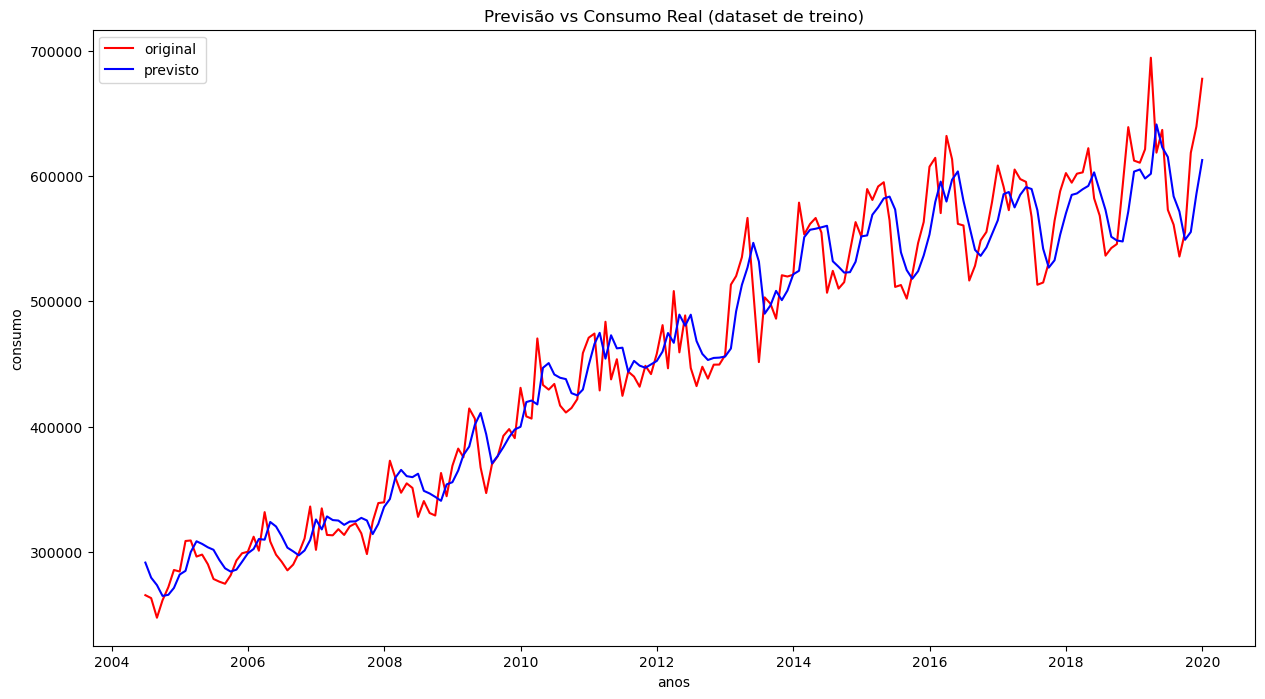

In [1110]:
plt.figure(figsize=(15, 8))
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(treino_previsao_inv)], y_train_inv, label="original", color="red")
plt.plot(df.index[TIME_STEPS:TIME_STEPS+len(treino_previsao_inv)], treino_previsao_inv, label="previsto", color="blue")
plt.title("Previsão vs Consumo Real (dataset de treino)")
plt.xlabel("anos")
plt.ylabel("consumo")
plt.legend()
plt.show()

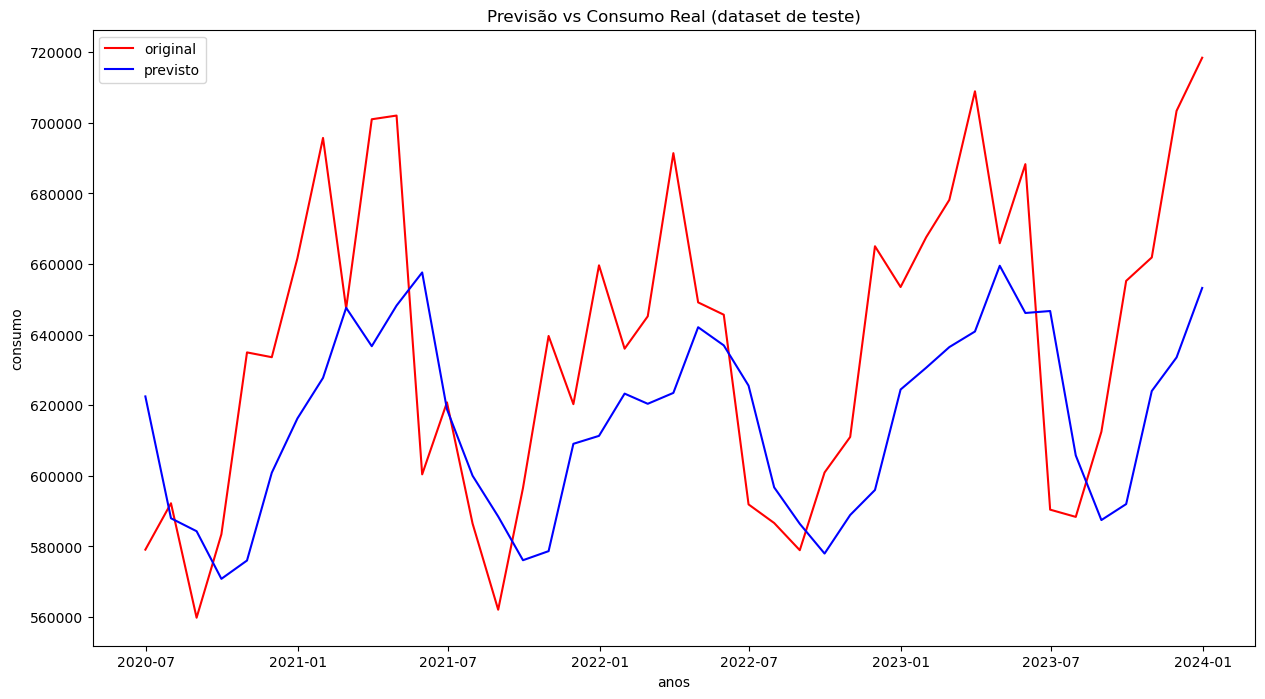

In [1111]:
plt.figure(figsize=(15, 8))
plt.plot(teste_df.index[TIME_STEPS:TIME_STEPS+len(teste_previsao_inv)], y_test_inv, label="original", color="red")
plt.plot(teste_df.index[TIME_STEPS:TIME_STEPS+len(teste_previsao_inv)], teste_previsao_inv, label="previsto", color="blue")
plt.title("Previsão vs Consumo Real (dataset de teste)")
plt.xlabel("anos")
plt.ylabel("consumo")
plt.legend()
plt.show()

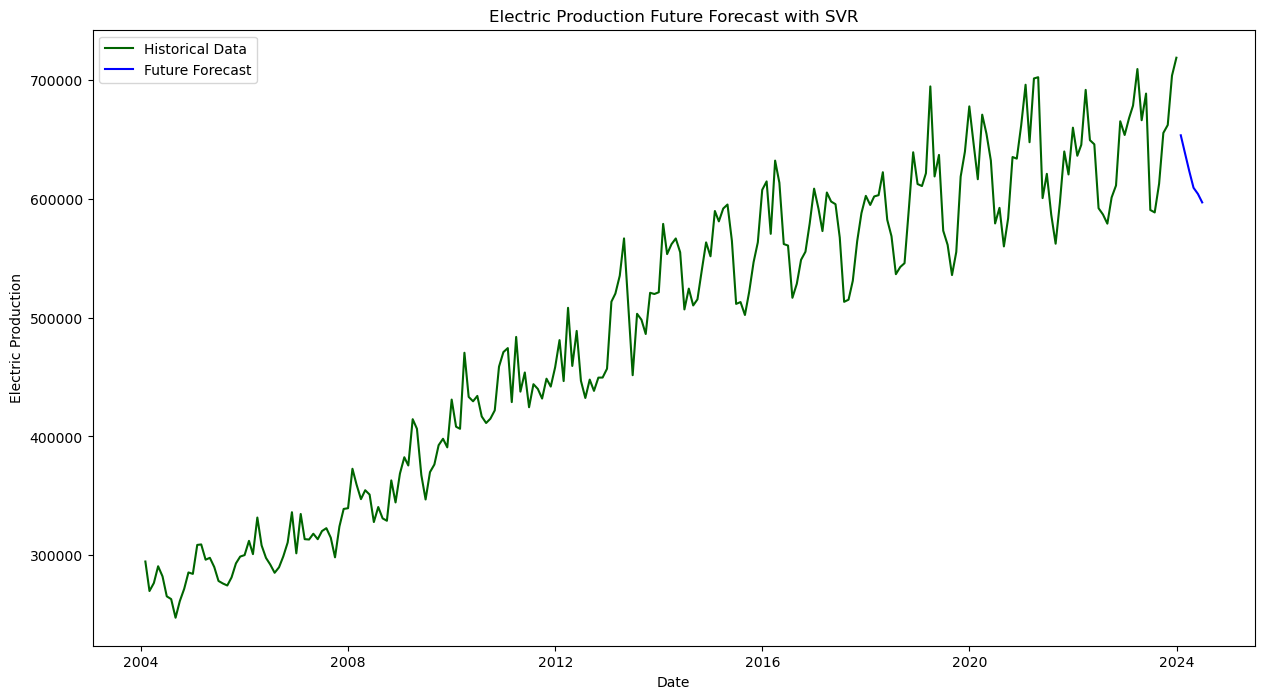

In [1112]:
future_steps = 6
last_sequence = X_test[-1]
future_forecast = []
for _ in range(future_steps):
    next_pred = modelo.predict(last_sequence.reshape(1, -1))
    future_forecast.append(next_pred[0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

future_forecast_inv = escalador.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Inverse scaling for future forecast
future_forecast_inv = escalador.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Generate future timestamps
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='M')[1:]

# Plotting the future forecast
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['consumo'], label='Historical Data', color='darkgreen')
plt.plot(future_dates, future_forecast_inv, label='Future Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Future Forecast with SVR')
plt.legend()
plt.show()

In [1113]:
future_forecast_inv

array([[653227.60727016],
       [638550.41338662],
       [623028.99083364],
       [609090.65693658],
       [603909.24661659],
       [596794.28342501]])

In [1114]:
future_dates

DatetimeIndex(['2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30'],
              dtype='datetime64[ns]', freq='M')

In [1115]:
real_ano_2024_6_meses = np.array([729168,695934,739737,	728841,	679839, 655958])

In [1116]:
mean_absolute_error(real_ano_2024_6_meses, future_forecast_inv)

84145.96692189957

In [1117]:
mean_absolute_percentage_error(real_ano_2024_6_meses, future_forecast_inv)

0.11842606162369096

# Treino com todos os dados (apenas um teste)

In [1118]:
teste=df.loc["2023-01-01":].copy() #vamos usar os 12 meses anteriores para prever os 12 meses posteriores
treino = df.loc[:"2022-12-31"].copy()

#teste = df.iloc[-5:].copy()
#treino = df.iloc[:df.shape[0]-5].copy()


In [1119]:
treino

,consumo
data,
2004-01-31,294798
2004-02-29,269980
2004-03-31,276717
2004-04-30,290815
2004-05-31,282304
...,...
2022-08-31,578924
2022-09-30,600944
2022-10-31,611010


In [1120]:
teste

,consumo
data,
2023-01-31,667611
2023-02-28,678190
2023-03-31,708950
2023-04-30,665903
2023-05-31,688309
2023-06-30,590411
2023-07-31,588363
2023-08-31,612484
2023-09-30,655231


In [1121]:
escalador_2 = MinMaxScaler()
treino_escalado_2=escalador_2.fit_transform(treino)
teste_escalado_2 = escalador_2.transform(teste)

In [1122]:
TIME_STEPS = 5
X_train_2, y_train_2 = create_dataset(treino_escalado_2, treino_escalado_2, TIME_STEPS)
X_test_2, y_test_2 = create_dataset(teste_escalado_2, teste_escalado_2, TIME_STEPS)

In [1123]:
modelo_2 = SVR(kernel="rbf", gamma=0.05, epsilon=0.05, C=2)

In [1124]:
modelo_2.fit(X_train_2.reshape(X_train_2.shape[0], -1), y_train_2.ravel())

SVR(C=2, epsilon=0.05, gamma=0.05)

In [1125]:
future_steps = 6

future_forecast = []
last_sequence = X_test_2[-1]
for _ in range(future_steps):
    next_pred = modelo_2.predict(last_sequence.reshape(1, -1))
    
    future_forecast.append(next_pred[0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    

future_forecast_inv_2=escalador_2.inverse_transform(np.array(future_forecast).reshape(-1, 1))

In [1126]:
mean_absolute_percentage_error(real_ano_2024_6_meses, future_forecast_inv_2)

0.10183547656750323

In [1127]:
real_ano_2024_6_meses

array([729168, 695934, 739737, 728841, 679839, 655958])

In [1128]:
future_forecast_inv_2

array([[663686.37171455],
       [650260.20882188],
       [636414.49171478],
       [621347.97122248],
       [614954.80405785],
       [608086.12305961]])